In [2]:
import sys
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet")
sys.path.insert(0, "/data/hpcdata/users/anddon76/icenet/icenet-experimental/backbone-v2")
import os
os.chdir("/data/hpcdata/users/anddon76/icenet/icenet-experimental/")
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

## 1. Figure Out Projection Bounds

In [3]:
amsr = xr.open_dataset("/data/twins/wip/common/sic/amsr2/south/asi-AMSR2-s6250-20230102-v5.4.nc")
amsr

/data/hpcdata/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:              (x: 1264, y: 1328)
Coordinates:
  * x                    (x) float64 -3.947e+06 -3.941e+06 ... 3.947e+06
  * y                    (y) float64 -3.947e+06 -3.941e+06 ... 4.347e+06
Data variables:
    polar_stereographic  |S1 ...
    z                    (y, x) float32 ...
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.4.3 (r19528) [64-bit]
    history:      Tue Jan 03 05:27:52 2023: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.2.3, released 2017/11/20

In [4]:
amsr.polar_stereographic.spatial_ref

'PROJCS["NSIDC Sea Ice Polar Stereographic South",GEOGCS["Unspecified datum based upon the Hughes 1980 ellipsoid",DATUM["Not_specified_based_on_Hughes_1980_ellipsoid",SPHEROID["Hughes 1980",6378273,298.279411123064,AUTHORITY["EPSG","7058"]],AUTHORITY["EPSG","6054"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4054"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",-70],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","3412"]]'

Ok, so based on this, it looks like we're dealing with the [NSIDC Sea Ice Polar Stereographic South](https://nsidc.org/data/user-resources/help-center/guide-nsidcs-polar-stereographic-projection) projection with EPSG code 3412. We should be able to reproject ERA5 and other datasets to this standard.

## 2. Load Example ERA5 and Reproject

In [5]:
tas = xr.open_dataset("/data/hpcdata/users/anddon76/icenet/icenet-experimental/data/era5/south/tas/2023.nc")
tas

<xarray.Dataset>
Dimensions:  (time: 359, yc: 432, xc: 432)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-12-25
  * yc       (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * xc       (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
Data variables:
    tas      (time, yc, xc) float32 ...

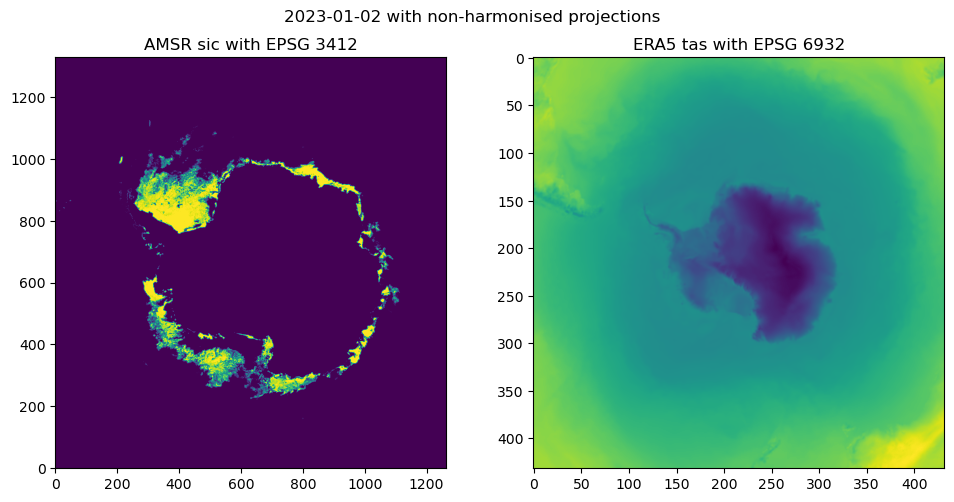

In [6]:
img_amsr = amsr.z.to_numpy()
img_amsr = np.where(np.isnan(img_amsr), 0, img_amsr)
img_tas = tas.sel(time=pd.to_datetime("2023-01-02"), method="nearest").to_array().squeeze()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_amsr, origin="lower")
ax[0].set_title("AMSR sic with EPSG 3412")
ax[1].imshow(img_tas)
ax[1].set_title("ERA5 tas with EPSG 6932")
plt.suptitle("2023-01-02 with non-harmonised projections")
plt.tight_layout()

Note how these are different projections by a longshot. Much more ocean in the ERA5 projection. But no projection string embedded in the ERA5 netCDF file. Going to have to do some digging here.

Following the links below:
* https://esc24.github.io/iris/iris/iris/cube.html
* https://github.com/environmental-forecasting/preprocess-toolbox/blob/main/preprocess_toolbox/dataset/process.py
* icenet.utils.data

In [7]:
import iris
amsr_cube = iris.load_cube("/data/twins/wip/common/sic/amsr2/south/asi-AMSR2-s6250-20230102-v5.4.nc")
amsr_cube

/tmp/ipykernel_47838/716723313.py:2: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  amsr_cube = iris.load_cube("/data/twins/wip/common/sic/amsr2/south/asi-AMSR2-s6250-20230102-v5.4.nc")


<iris 'Cube' of z / (unknown) (projection_y_coordinate: 1328; projection_x_coordinate: 1264)>

In [8]:
from iris.coords import DimCoord
tas_cube = iris.load_cube("/data/hpcdata/users/anddon76/icenet/icenet-experimental/data/era5/south/tas/2023.nc")
tas_cube.add_dim_coord(DimCoord(tas.yc.to_numpy(), standard_name="projection_y_coordinate", units="m", var_name="yc"), 1)
tas_cube.add_dim_coord(DimCoord(tas.xc.to_numpy(), standard_name="projection_x_coordinate", units="m", var_name="xc"), 2)
cs = amsr_cube.coord_system()
tas_cube.coord('projection_y_coordinate').coord_system = cs #iris.coord_systems.GeogCS(6367470.0)
tas_cube.coord('projection_x_coordinate').coord_system = cs #iris.coord_systems.GeogCS(6367470.0)
tas_cube

/data/hpcdata/users/anddon76/micromamba/envs/icenet-3.11/lib/python3.11/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF grid mapping variable 'lambert_azimuthal_equal_area', referenced by netCDF variable 'tas'
  warnings.warn(message % (name, nc_var_name))


2 Metre Temperature (K),time,projection_y_coordinate,projection_x_coordinate
Shape,359,432,432
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x


In [9]:
tas_cube.coord_system()

PolarStereographic(central_lat=-90.0, central_lon=0.0, false_easting=0.0, false_northing=0.0, true_scale_lat=-70.0, ellipsoid=GeogCS(semi_major_axis=6378273.0, semi_minor_axis=6356889.449))

In [10]:
amsr_cube.coord_system()

PolarStereographic(central_lat=-90.0, central_lon=0.0, false_easting=0.0, false_northing=0.0, true_scale_lat=-70.0, ellipsoid=GeogCS(semi_major_axis=6378273.0, semi_minor_axis=6356889.449))

In [11]:
tas_cube_on_amsr = tas_cube.regrid(amsr_cube,
                                   iris.analysis.Linear())

In [12]:
iris.save(tas_cube_on_amsr, "tas_cube_on_amsr.temp.nc")

In [13]:
tas_cube_on_amsr.data.shape

(359, 1328, 1264)

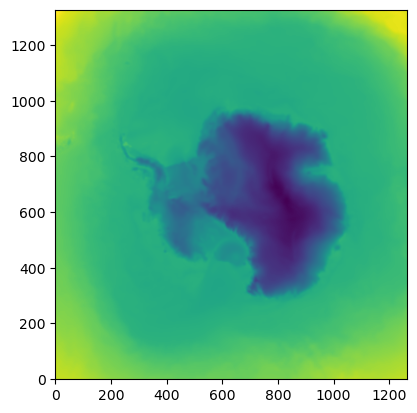

In [14]:
plt.imshow(tas_cube_on_amsr.data[0], origin="lower")

In [15]:
tas_da_on_amsr = xr.open_dataset("/data/hpcdata/users/anddon76/icenet/icenet-experimental/tas_cube_on_amsr.temp.nc")
tas_da_on_amsr

<xarray.Dataset>
Dimensions:              (time: 359, y: 1328, x: 1264)
Coordinates:
  * time                 (time) datetime64[ns] 2023-01-01 ... 2023-12-25
  * y                    (y) float64 -3.947e+06 -3.941e+06 ... 4.347e+06
  * x                    (x) float64 -3.947e+06 -3.941e+06 ... 3.947e+06
Data variables:
    tas                  (time, y, x) float32 ...
    polar_stereographic  int32 ...
Attributes:
    Conventions:  CF-1.7

## 3. Verify

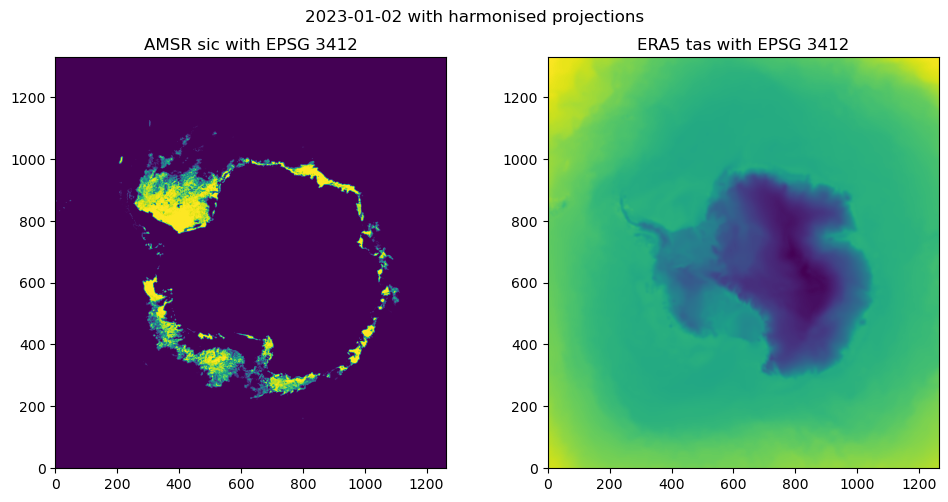

In [ ]:
img_tas_on_amsr = tas_da_on_amsr.sel(time=pd.to_datetime("2023-01-02")).tas.to_numpy()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_amsr, origin="lower")
ax[0].set_title("AMSR sic with EPSG 3412")
ax[1].imshow(img_tas_on_amsr, origin="lower")
ax[1].set_title("ERA5 tas with EPSG 3412")
plt.suptitle("2023-01-02 with harmonised projections")
plt.tight_layout()

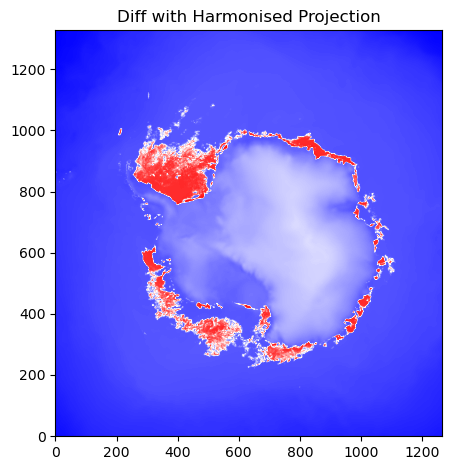

In [17]:
plt.imshow(img_amsr - img_tas_on_amsr, origin="lower", cmap="bwr")
plt.title("Diff with Harmonised Projection")
plt.tight_layout()

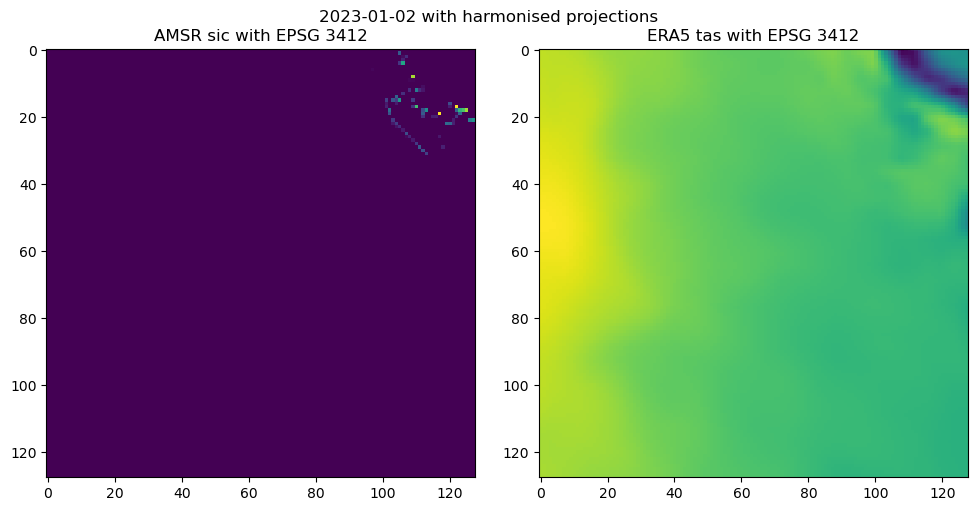

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_amsr[::-1][525:653, 150:278])
ax[0].set_title("AMSR sic with EPSG 3412")
ax[1].imshow(img_tas_on_amsr[::-1][525:653, 150:278])
ax[1].set_title("ERA5 tas with EPSG 3412")
plt.suptitle("2023-01-02 with harmonised projections")
plt.tight_layout()